# "Intro to hypothesis tests"
> "Normal distribution and & Z-test"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- hide: false

// width of the content area
// can be set as "px" or "%"
$content-width:    800px;
$on-palm:          800px;
$on-laptop:        800px;
$on-medium:        800px;
$on-large:         1200px;

 The lectures at LeWagon bootcamp are great. A wide range of practical information is packed in a 2 hour lecture. However, it is virtually impossible to convey a complex concept in depth within such short time. One has to dig deep into the topic after the lectures to fully understand what's really going on. As a current student at the bootcamp, I am writing these posts to fill the gaps between my understanding of the topic.
 
 Ultimately, I would like to find the answer for the following question:\
 **'So why do we learn this topic for data science boot camp.'**

In [517]:
#hide
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import altair as alt
import random
import scipy

## TLDR
**Central limit theorem**
1) Most real world data distribution do not follow normal distribution.
2) Many statistical tests and scores assume that the data of interest follows normal distribution.
3) In practice, data that follows almost any distribution can be transformed into normal distribution based on central limit theorem.
4) After transformation, one can test how close the distribution is to normal distribution using several parameters including skewness and kurtosis.


**Z-statistics**

1) If a data distribution follows normal distribution, 68.39%, 95.4% and 99.8% of population lie within 1, 2 and 3 standard deviations away from mean respectively.

<img src = 'https://media.cheggcdn.com/media/e56/e5610b04-9caa-4ad6-b511-32468a61f127/CL-23900V_image_007.png' style="width: 400px;"/>

2) Z score lets you express how far you data lies from the mean in terms of number of standard deviations, thereby highlighting the significance of your data.

<img src = 'https://www.nku.edu/~statistics/Normal2.gif'>

<img src = 'https://www.nku.edu/~statistics/images2/Normal2.gif'>

Let's say the above left figure represents human IQ distribution. It is difficult to understand how low is IQ 95 compare to the population mean of 103.\
Using z-score, above right figure expresses the same statistic in terms of standard deviation of normal distribution. IQ 95 is 1.48 standard deviations away from population mean. Anyone with some understanding of normal distribution will understand the significance of the data right away.

3) Area under probabilty distribution curve represents probability of getting a sample from the region.

Area under curve represents the probability of getting sample from the region. Now we know that only less than 7% have IQ lower than 95. (Above figures are not actually about human IQ. IQ score of 95 is not too bad in fact. So don't be frustrated.)


## Why is Central Limit Theorem (CLT) Relevant?

Once you have a dataset of interest, you would want to describe it and draw conclusion statistically (descriptive and inferential statistics). For that, you will want to use a set of existing statistical tests and scores (Z-score, t-test, ANOVA, etc). Many of these tests and scores share a common assumption: **the data is normally distributed**. Unless you are willing to develop your own tests (which is not a trivial task), you will have to make sure your dataset meets the assumption.

Unfortunately, many of the distributions you will encounter are not normal. But do not panic. We have a way to transform any distribution into approximately normal distribution - in fact, this is why most statistical techniques assume normal distribution. As you have already learned in the previous lecture, central limit theorem provides the theoretical basis for the transformation.

CLT states that the sampling distribution of the mean of any independent,random variable will be normal or nearly normal, if the sample size is large enough. **In other words, the distribution of the mean of means will follow normal distribution as long as the sample size of each measurement is big enough regardless of the original population distribution.** 

For formal proof of central limit theorem, check [this paper.](https://www.cs.toronto.edu/~yuvalf/CLT.pdf)

In [575]:
#collapse
#Read CSV file
path = 'dataset/uk_income_distribution_2020.xlsx'
df = pd.read_excel(path)
df.drop('Unnamed: 0', inplace = True, axis = 1)
df.columns = ['Income_band', 'Count(1000s)']

#The data provides household count. Procedure to make each row represents a sample.
dist_df = pd.DataFrame()
for i, j in df.iterrows():
    temp_df = pd.DataFrame((random.choices(range(int(j['Income_band']), int(j['Income_band']+1000)), k= int(j['Count(1000s)']))))
    dist_df = pd.concat([dist_df, temp_df])
dist_df.columns = ['income']

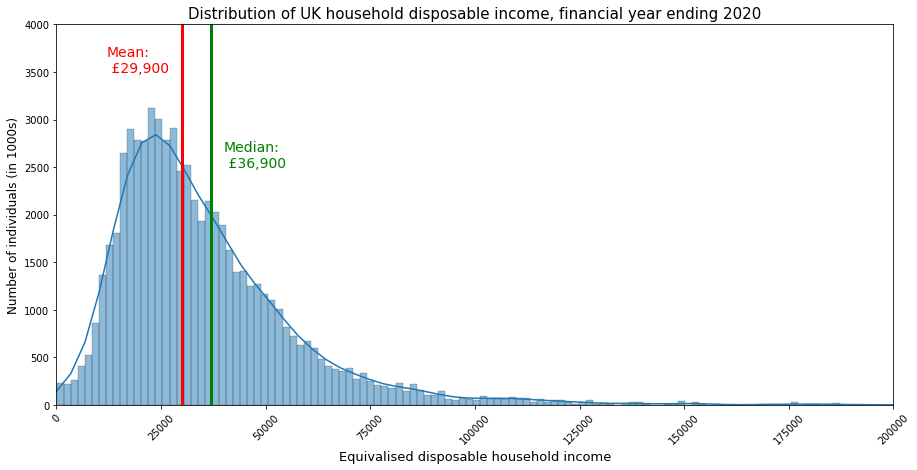

In [576]:
#collapse
plt.figure(figsize=(15, 7))
ax = sns.histplot(dist_df, bins = 400, legend = False, kde = True)
plt.axvline(29900, color = 'red', lw = 3)
plt.axvline(36900, color = 'green', lw = 3)
#tick_spacing = 10000
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation = 45)
plt.xlim(0, 200000)
plt.ylim(0, 4000)
plt.title('Distribution of UK household disposable income, financial year ending 2020', fontsize = 15)
plt.xlabel('Equivalised disposable household income', fontsize=13)
plt.ylabel('Number of individuals (in 1000s)', fontsize = 12)

plt.text(12000, 3500, 'Mean:\n £29,900', fontsize = 14, color = 'red')
plt.text(40000, 2500, 'Median:\n £36,900', fontsize = 14, color = 'green');

/home/byungjae/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


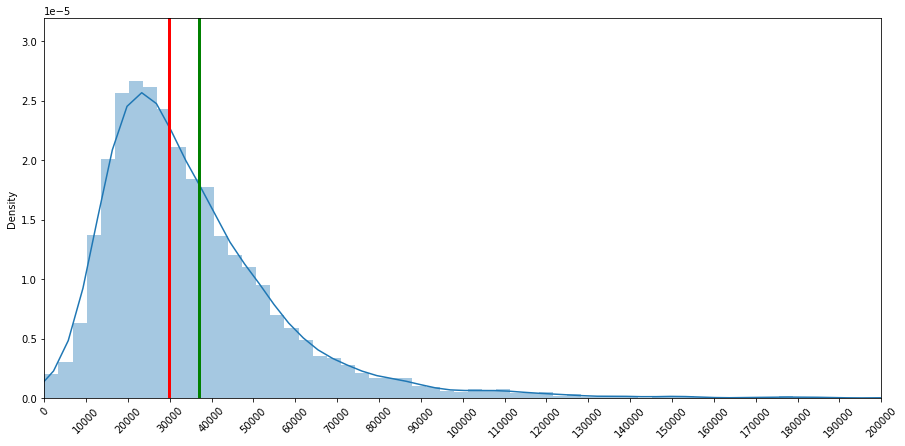

In [577]:
#hide
plt.figure(figsize=(15, 7))
ax = sns.distplot(dist_df, bins = 200)
plt.axvline(29900, color = 'red', lw = 3)
plt.axvline(36900, color = 'green', lw = 3)
tick_spacing = 10000
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xticks(rotation = 45)
plt.xlim(0, 200000)
plt.ylim(0, 3.2e-5);

In [584]:
np.sum(cul_prob_df['income'])

0.9999999999999999

In [726]:
alt.data_transformers.disable_max_rows()
dist_short_df = dist_df[dist_df['income']<200000]


slider = alt.binding_range(min=0, max=100, step=1, name='cutoff:')
selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
                                bind=slider, init={'cutoff': 50})

alt_dist = alt.Chart(dist_short_df).transform_bin(
            'income_bin', 'income', bin=alt.Bin(extent=[0, 200000], step=3000)
        ).transform_joinaggregate(
            count='count()', groupby=['income_bin']  
        ).mark_bar().encode(
            alt.X('income_bin:Q', bin='binned'),
            alt.X2('income_bin_end'),
            alt.Y('count:Q'),
            color=alt.condition(
                alt.datum.income_bin_end <= selector.cutoff,
                alt.value("lightblue"),  # The positive color
                alt.value("lightgray")  # The negative color
            )
        ).add_selection(
            selector
        )

alt_cul = alt.Chart(dist_short_df).transform_density(
            density = 'income',
            as_=["value", "density"],
            cumulative = True,
            steps = 200
            ).mark_area(clip = True).encode(
                alt.X("value:Q"),
                alt.Y("density:Q"),
                color=alt.condition(
                    alt.datum.value <= selector.cutoff,
                    alt.value("blue"),  # The positive color
                    alt.value("lightgray")  # The negative color
                )
            ).add_selection(
                selector
            )
                
            
alt_cul

alt.Chart(...)

In [853]:
#collapse
#Modifying dataframe --> binning, adding cumulative probability
bin_size = 500
bins = range(0, 676000, bin_size)
dist_df['binned'] = pd.cut(dist_df['income'], bins)
binned_df = dist_df.groupby('binned').count()
binned_df['bin'] = binned_df.index
binned_df['bin'] = binned_df['bin'].apply(lambda x: x.left)
binned_df['cum_sum'] = binned_df[['income']].cumsum()
binned_df['cum_density'] = binned_df['cum_sum']/65614

In [855]:
#collapse
#Plotting interactuve plot
slider = alt.binding_range(min=0, max=200000, step=1, name='Income Threshold:')
selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
                                bind=slider, init={'cutoff': 30000})

chart_dist = alt.Chart(binned_df).mark_bar(clip=True).encode(
            alt.X('bin:Q', scale=alt.Scale(domain=(10000, 200000)), title='Income band'),
            alt.Y('income:Q'),
            color=alt.condition(
                alt.datum.bin <= selector.cutoff,
                alt.value("navy"),  # The positive color
                alt.value("lightgray")  # The negative color
            )
        ).add_selection(
            selector
        )

chart_density = alt.Chart(binned_df).mark_bar(clip=True).encode(
                    alt.X('bin:Q', scale = alt.Scale(domain=(10000, 200000)), title='Income band'),
                    alt.Y('cum_density:Q', title = 'Cumulative probability'),
                    color = alt.condition(
                                alt.datum.bin <= selector.cutoff,
                                alt.value("navy"),  # The positive color
                                alt.value("lightgray")  # The negative color)
                            )
                ).add_selection(
                    selector)
chart_dist|chart_density


alt.HConcatChart(...)